In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from  sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)
import gc

In [2]:
def _reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
features_list = ['BASE','PART']
dfs = [pd.read_feather(f'../features/data/{feature}_train.feather') for feature in features_list]
df = pd.concat(dfs,axis=1)

In [5]:
df = _reduce_mem_usage(df)

Mem. usage decreased to 6905.94 Mb (65.4% reduction)


In [6]:
df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,user_part_mean,user_part_sum,part_ans_mean
0,0,0,115,5692,0,1,3,1,NaN,NaN,5692.0,3.0,5,151,151.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.333252,1.0,0.610840
1,1,56943,115,5716,0,2,2,1,37000.0,0.0,5716.0,2.0,5,168,168.0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.000000,1.0,0.610840
2,2,118363,115,128,0,0,0,1,55000.0,0.0,128.0,0.0,1,131 149 92,131.0,149.0,92.0,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,0.742188
3,3,131167,115,7860,0,3,0,1,19000.0,0.0,7860.0,0.0,1,131 104 81,131.0,104.0,81.0,NaN,NaN,NaN,NaN,None,NaN,1.000000,1.0,0.742188
4,4,137965,115,7922,0,4,1,1,11000.0,0.0,7920.0,1.0,1,131 149 92,131.0,149.0,92.0,NaN,NaN,NaN,NaN,None,NaN,1.000000,2.0,0.742188


In [18]:
df[(df['user_id'] == 115) & (df['part'] == 7)].head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,correct_answer,part,tags,tags1,tags2,tags3,tags4,tags5,tags6,tag,type_of,l_type_of,user_part_mean,user_part_sum,part_ans_mean


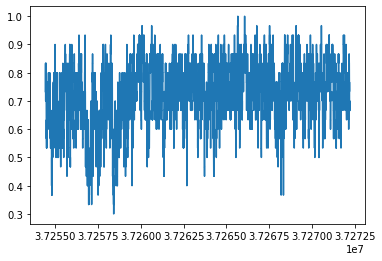

In [43]:
plt.plot(df[(df['user_id'] == 801103753)]['answered_correctly'].rolling(30).mean())

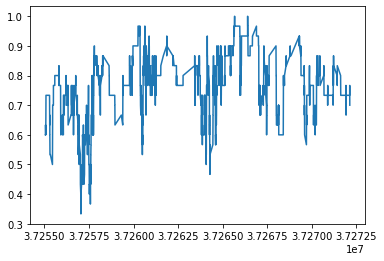

In [33]:
plt.plot(df[(df['user_id'] == 801103753) & (df['part'] == 3)]['answered_correctly'].rolling(30).mean())

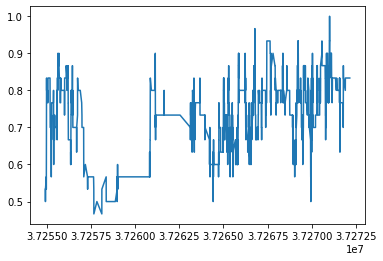

In [42]:
plt.plot(df[(df['user_id'] == 801103753) & (df['part'] == 6)]['answered_correctly'].rolling(30).mean())

In [5]:
create_cols = ['past_correctly_sum','past_not_correctly_sum','past_correctly_mean']
train = pd.read_feather('../features/data/USER_ID_train.feather')
# train = train[['user_id','answered_correctly']]

In [6]:
train.head()

,past_correctly_sum,past_not_correctly_sum,past_correctly_mean
0,NaN,NaN,NaN
1,1.0,0.0,1.0
2,2.0,0.0,1.0
3,3.0,0.0,1.0
4,4.0,0.0,1.0


In [7]:
USE_COLS_BASE = ['timestamp','content_id','content_type_id','task_container_id','prior_question_elapsed_time','prior_question_had_explanation','bundle_id',\
                'part','tags1','tags2','tags3','tags4','tags5','tags6']
USE_COLS_PART = ['user_part_mean','user_part_sum']
USE_COLS_USER_ID = ['past_correctly_sum''past_not_correctly_sum','past_correctly_mean']
USE_COLS = USE_COLS_BASE + USE_COLS_PART + USE_COLS_USER_ID

In [8]:
USE_COLS

['timestamp',
 'content_id',
 'content_type_id',
 'task_container_id',
 'prior_question_elapsed_time',
 'prior_question_had_explanation',
 'bundle_id',
 'part',
 'tags1',
 'tags2',
 'tags3',
 'tags4',
 'tags5',
 'tags6',
 'user_part_mean',
 'user_part_sum',
 'past_correctly_sumpast_not_correctly_sum',
 'past_correctly_mean']

In [3]:
train_df = pd.read_feather('../data/input/train.feather')

In [4]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,None
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [7]:
user_ans_mean = train_df[train_df['answered_correctly'] != -1][['user_id','answered_correctly']].groupby('user_id').agg(['sum','mean','count'])

In [9]:
user_ans_mean.columns = ['past_correctly_sum','past_correctly_mean','count']

In [10]:
user_ans_mean

,past_correctly_sum,past_correctly_mean,count
user_id,,,
115,32,0.695652,46
124,7,0.233333,30
2746,11,0.578947,19
5382,84,0.672000,125
8623,70,0.642202,109
...,...,...,...
2147470770,173,0.765487,226
2147470777,520,0.691489,752
2147481750,38,0.760000,50


In [4]:
correct_list_1 = []
correct_list_0 = []
correct_mean = []
user_list = []
for _,data in tqdm(train_df.groupby('user_id')):
    correct_sum_1 = 0
    correct_sum_0 = 0
    count = 0
    for correct in data['answered_correctly']:
        correct_sum_1 += correct == 1
        correct_sum_0 += correct == 0
        count += 1
    correct_list_1.append(correct_sum_1)
    correct_list_0.append(correct_sum_0)
    correct_mean.append(correct_sum_1/count)
        
train_df['past_correctly_sum'] = correct_list_1
train_df['past_not_correctly_sum'] = correct_list_0
train_df['past_correctly_mean'] = correct_mean

100%|██████████| 393656/393656 [02:09<00:00, 3036.00it/s]


In [5]:
train_df_last = train_df[~train_df["user_id"].duplicated(keep='last')]

In [6]:
train_df_last.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,past_correctly_sum,past_not_correctly_sum,past_correctly_mean,user_count
45,45,668090043,115,3364,0,41,1,1,14333.0,False,31,14,0.673913,46
75,75,571323,124,7219,0,15,1,0,6500.0,False,7,22,0.233333,30
95,95,835457,2746,484,0,19,0,1,20000.0,True,10,8,0.500000,20
223,223,2101551456,5382,4070,0,127,3,0,22000.0,True,84,40,0.656250,128
335,335,862338736,8623,969,0,99,0,1,18000.0,True,69,39,0.616071,112


In [7]:
test_df = pd.read_csv('../data/input/example_test.csv')

In [8]:
test_df.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN


In [9]:
train_df_last.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,past_correctly_sum,past_not_correctly_sum,past_correctly_mean,user_count
45,45,668090043,115,3364,0,41,1,1,14333.0,False,31,14,0.673913,46
75,75,571323,124,7219,0,15,1,0,6500.0,False,7,22,0.233333,30
95,95,835457,2746,484,0,19,0,1,20000.0,True,10,8,0.500000,20
223,223,2101551456,5382,4070,0,127,3,0,22000.0,True,84,40,0.656250,128
335,335,862338736,8623,969,0,99,0,1,18000.0,True,69,39,0.616071,112


In [11]:
test_user = test_df['user_id'].unique()
train_test = train_df_last[train_df_last['user_id'].isin(test_user)]

In [18]:
del train_df

In [20]:
gc.collect()

3275

In [21]:
train_test.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,past_correctly_sum,past_not_correctly_sum,past_correctly_mean,user_count
400926,400926,64497311425,7792299,2505,0,674,2,1,23000.0,True,550,285,0.622877,883
4623025,4623025,301033,98059812,5673,0,6,2,0,41000.0,False,4,2,0.571429,7
13349385,13349385,62725820527,288641214,11912,0,262,0,0,38000.0,True,187,85,0.675090,277
14430340,14430340,27465254888,311890082,2250,0,211,2,0,27333.0,True,201,106,0.640127,314
14802926,14802926,13679681662,319060572,2590,0,620,0,0,29000.0,True,676,468,0.575319,1175
